In [1]:
# Imports
import os
import datetime

import torch
from torch.utils.data import TensorDataset, Dataset
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Import PySpark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.pandas.frame import DataFrame
import pyspark.pandas as ps

# Import utils
from utils import get_global_config, build_spark_session, train, evaluate

# Always import wfdb last because it might break jupyter
import wfdb


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay,roc_curve,auc

# Initial setup
cfg = get_global_config()
# spark = build_spark_session()

/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/pyspark/pandas/__init__.py:49: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [81]:
# Defining paths for local
# DATAPATH = '/Users/michaelscott/bd4h/project/data' 
# MIMICPATH = DATAPATH + '/mimic3/mimic-iii-clinical-database-1.4'
# DEMOPATH = DATAPATH + '/mimic3/mimic-iii-clinical-database-demo-1.4'
# WAVEFPATH = DATAPATH + '/waveform/physionet.org/files/mimic3wdb-matched/1.0'
# OUTPUTPATH = './output'

# function for creating datasets
def create_batch(df, window_size=cfg['WINDOWSIZE'], overlap_pct=cfg['RECORDOVERLAP']):
	# Convert to numpy array of 120 rows each
	# with intersect of 40%
	# Set the window size to 120 and the overlap to 40%
	overlap = int(window_size * overlap_pct)

	# Convert the DataFrame to a numpy array
	# data = df.values
	data = df

	if len(data) == window_size:
		# Convert the list of windows to a numpy array
		# Create a new axis to to specify batch size of 1
		windows = np.array(data)[np.newaxis, :]

	else:
		# Use the rolling method to create the sliding windows
		windows = []
		for i in range(0, len(data) - window_size, window_size - overlap):
			window = data[i:i+window_size]
			# Count number of Nan values in the window
			# If there are any, drop the window
			if window.isnull().sum().sum() == window.count().sum():
				print("dropping empty array")
				pass
			else:
				windows.append(window.fillna(0))
		# Convert the list of windows to a numpy array
		windows = np.array(windows)
		
	# converts from (n, 120, 10) to (n, 10, 120) 
	return np.swapaxes(windows,1,2)

def get_arr(arr, y):
	if arr.shape[0] > 1:
		return np.array([y]*arr.shape[0]).squeeze()
	else:
		return np.array([y]*arr.shape[0])

def load_dataset(x,age_arr,y):
	"""
	:param path: a path to the seizure data CSV file
	:return dataset: a TensorDataset consists of a data Tensor and a target Tensor
	"""
	# Casting in pytorch tensor
	data = torch.from_numpy(x).type(torch.FloatTensor)
	target = torch.from_numpy(y).type(torch.FloatTensor) # BCE with logit expects target to be float. CrossEntropy expects long
	age = torch.from_numpy(age_arr).type(torch.FloatTensor)

	# x[torch.isnan(x)] = 0

	# Need to be of size (N, Cn, L)
	# N: batch size
	# Cn: number of channels
	# L: length of the sequence
	data = data.reshape((data.shape[0], data.shape[1], data.shape[2]))
	dataset = TensorDataset(data, age.float(), target.float())

	return dataset

# Functions for waveform
def get_waveform_path(record_name):
	patient_id = record_name[0:7]
	return cfg['WAVEFPATH'] + f'/{patient_id[0:3]}/{patient_id}/{record_name}'

def plot_waveform(ca_time_str = '2104-12-05 08:40:00', record_name = 'p087675-2104-12-05-03-53n'):
	# Get waveform data
	patient_path = get_waveform_path(record_name)
	record = wfdb.rdrecord(patient_path, channel_names=cfg['CHANNEL_NAMES'])

	# Select only HR from the plots, not with the channels parameter
	fig = wfdb.plot_wfdb(record=record, title=record_name[0:7], figsize=(10,15), return_fig=True)
	ax_list = fig.axes

	# get time when recording started
	base_time = datetime.datetime.combine(record.__dict__['base_date'], 
							record.__dict__['base_time'])

	# Create datetime using strptime
	ca_time = datetime.datetime.strptime(ca_time_str, '%Y-%m-%d %H:%M:%S')

	# find time delta between base_time and ca_time
	# Convert it to an int that represents the number of seconds
	time_delta = int((ca_time - base_time).total_seconds())

	# Plot a vertical line at time_delta
	if time_delta > 0:
		for ax in ax_list:
			ax.axvline(x=time_delta, color='red', linestyle='--',)
	else:
		# change title of fig
		fig.suptitle('Cardiac Arrest Time is before the start of the recording')

	fig.show()

	display(record.__dict__)

def get_base_time(record_name):
	basetime = record_name[8:]
	basetime = basetime.strip().strip('n')
	return basetime

def get_record(record_name):
	patient_path = get_waveform_path(record_name)
	return wfdb.rdrecord(patient_path, channel_names=cfg['CHANNEL_NAMES'])

def get_ending_time(record_name):
	"""Ending time is the end time of a record"""
	# Get waveform data
	record = get_record(record_name)
	
	# get time when recording started
	base_time = datetime.datetime.combine(record.__dict__['base_date'], 
							record.__dict__['base_time'])
	
	duration = record.__dict__['sig_len'] * (1/record.__dict__['fs']) 

	# Add duration to base time
	end_time = base_time + datetime.timedelta(seconds=duration)

	record_present = [0 for i in range(len(cfg['CHANNEL_NAMES']))]

	# One hot encode the presence of signals
	for idx, val in enumerate(cfg['CHANNEL_NAMES']):
		if val in record.__dict__['sig_name']:
			record_present[idx] = 1

	return end_time, record_present

""" Model"""
# bookmark
class MyCNN(nn.Module):
	def __init__(self):
		# self.MAGIC_NUMBER = 16*41
		self.MAGICNUM = 26
		super(MyCNN, self).__init__()
		self.conv1 = nn.Conv1d(in_channels=10, out_channels=4, kernel_size=5)
		self.conv2 = nn.Conv1d(in_channels=4, out_channels=1, kernel_size=5)
		self.pool = nn.MaxPool1d(kernel_size=3, stride=2)
		self.out1 = nn.Linear(in_features=567, out_features=1)

		self.dropout = nn.Dropout(0.6)
		self.lstm = nn.LSTM(input_size = self.MAGICNUM, hidden_size=16, num_layers=2)
		self.out = nn.Linear(in_features=16, out_features=1, bias=True)
		self.out2 = nn.Linear(in_features=16, out_features=1, bias=True)

		self.age_fn = nn.Linear(in_features=1, out_features=1, bias=True)
		# Initialize age_fn with a very small weight
		# self.age_fn.weight.data =torch.full((1, 1), 0.000001)
		# self.age_fn.bias.data = torch.full((1, 1), 1.)
		torch.nn.init.constant_(self.age_fn.weight, .00005)
		torch.nn.init.constant_(self.age_fn.bias, 1)

	def forward(self, x, age):
		# print(x.size())
		x = torch.tanh(self.conv1(x))
		# print(x.size())
		x = self.pool(x)
		x=self.dropout(x)
		# print(x.size())
		x = torch.tanh(self.conv2(x))
		# print(x.size())
		x = self.pool(x)
		# print(x.size())
		x = self.dropout(x)
		# print(x.size())
		x = x.view(-1, self.MAGICNUM)
		x,_ = self.lstm(x)

		## version without age
		## this version works! Creates AUC of around 0.66
		# x = self.out(x).squeeze(1) 

		## version with age
		# x = torch.sigmoid(self.out(x))
		# print(age)
		# age_scale = torch.relu(self.age_fn(age.unsqueeze(1))) # add an additional dimension
		# print(age_scale)
		# x = (x*age_scale).squeeze(1) # squeeze 
		# print(x)

		# new version I'm trying
		# x = torch.sigmoid(self.out(x).squeeze(1))
		# print(age)
		# x = torch.sigmoid(self.out(x))
		# age_scale = torch.relu(age.unsqueeze(1) * 0.0001 + 1)
		# x = (x*age_scale).squeeze(1) # squeeze 

		# new version I'm trying
		# print(x.shape)
		# x = torch.sigmoid(self.out(x))
		# print(age.unsqueeze(1))
		# print(age.unsqueeze(1).shape)
		# age_scale = torch.relu(age.unsqueeze(1) * 0.0001 + 1)
		# print(age_scale)
		# print(x*age_scale)
		# x = (x*age_scale).squeeze(1) # squeeze 
		# print(x)

		# print(age)

		# new version I'm trying this still works!!
		x = self.out(x)
		age_scale = torch.relu(age.unsqueeze(1) * 0.0001 + 1)
		x = x * age_scale
		x = x.squeeze(1) 
		

		# this stops working...
		# x = torch.sigmoid(self.out(x))
		# age_scale = torch.relu(age.unsqueeze(1) * 0.0001 + 1)
		# x = x * age_scale
		# x = x.squeeze(1) 

		# this version does NOT work.
		# x = self.out(x)
		# input_age_scale = self.age_fn(age.unsqueeze(1))
		# age_scale = torch.relu(input_age_scale)
		# x = x * age_scale
		# x = x.squeeze(1) 
		
		return x

# Lesson on why you need age.unsqueeze(1):
# The error is most likely caused by the fact that age is a tensor of shape (32,),
#  which means it has 32 elements but is not a matrix. However, self.age_fn is a linear layer 
# that expects a matrix as input. Specifically, the in_features parameter is set to 1, which means 
# it expects a matrix of size (batch_size, 1).

# When you pass age to self.age_fn, it is implicitly expanded to a matrix of size (batch_size, 32)
#  by adding a singleton dimension at the end (since age has size (32,)), which is not what you want. 
# Instead, you should first unsqueeze the tensor along the second dimension (i.e., age.unsqueeze(1)) 
# to get a matrix of size (batch_size, 1), and then pass it to self.age_fn.

In [3]:
def get_patient_age(patient_id, currentdate):
    patient_df = pd.read_csv(f"{cfg['DATAPATH']}/patients_age.csv")
    dob = patient_df.query(f"SUBJECT_ID=={patient_id}")['dob'].values[0]
    # Convert to datetime.datetime object
    dob = datetime.datetime.strptime(dob, '%Y-%m-%d')
    age = (currentdate - dob).days/365
    return age 


In [4]:
def get_record_df(record_name, base_time=None, ca_time=None):
    # Retrieve record
    record = get_record(record_name)
    record_df = record.to_dataframe()

    # get the index of the first non-null value in the DataFrame
    if base_time: 
        actual_BASETIME = max(record_df.first_valid_index(), base_time)
    else:
        actual_BASETIME = record_df.first_valid_index()

    # get actual CA time as the final valid index of the entire dataframe
    # if the patient is dead
    if not ca_time:
        actual_CATIME = record_df.last_valid_index()
    else:
        actual_CATIME = ca_time

    # get actual splittime
    actual_SPLITTIME = actual_CATIME - datetime.timedelta(hours=2)

    actual_FINISHTIME = actual_CATIME - datetime.timedelta(minutes=5)

    # retrieve the first non-null record using the loc method
    record_df = record_df.loc[actual_BASETIME:actual_CATIME]

    for channel in cfg['CHANNEL_NAMES']:
        if channel not in record_df.columns:
            record_df[channel.replace(' ','_')] = 0

    # Sample at 5 second interval
    # take instantaneous value
    record_df = record_df.resample('5S').first()
    
    # perform preprocessing
    record_df = record_df.interpolate(method='linear')

    # define positive and negative
    negative_df = record_df.loc[:actual_SPLITTIME]
    positive_df = record_df.loc[actual_SPLITTIME:actual_FINISHTIME,:]

    return record_name[0:7], positive_df, negative_df

In [5]:
# Use patient 70723 as an example

# Information needed
# - SUBJECTID
# - STARTTIME (Cardiac arrest time)
# - RECORDNAME
# - BASETIME
# - ENDTIME 
# - Age

# We assume that all these information are conveninently stored in a table for us, 
# and we will start from there. Here, we define them as constants.
# Later we will move them to a table and read from there.

# Defining constants
SUBJECTID = 70723
RECORDNAME = 'p070723-2163-11-18-16-28n'
BASETIME = get_base_time(RECORDNAME)
ENDTIME, RECORD_PRESENT = get_ending_time(RECORDNAME)
CATIME = datetime.datetime.strptime('2163-11-20 11:37:20', '%Y-%m-%d %H:%M:%S') # ORIGINALLY 2163-11-18 15:06:00 (TIME OF NOTEEVENTS)
SPLITTIME = CATIME - datetime.timedelta(hours=2)
FINISHTIME = SPLITTIME - datetime.timedelta(minutes=5)
AGE = get_patient_age(70723, CATIME)

/var/folders/lc/wjv2l4cd19s4276v_sgzt_q40000gn/T/ipykernel_2048/2462383360.py:102: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'record_name': 'p070723-2163-11-18-16-28n',
 'n_sig': 5,
 'fs': 1,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 158241,
 'base_time': datetime.time(16, 28, 34),
 'base_date': datetime.date(2163, 11, 18),
 'comments': ['Location: micu/sicu'],
 'sig_name': ['HR', 'RESP', 'PULSE', 'SpO2', 'CVP'],
 'p_signal': array([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['3476173n.dat',
  '3476173n.dat',
  '3476173n.dat',
  '3476173n.dat',
  '3476173n.dat'],
 'fmt': ['16', '16', '16', '16', '16'],
 'samps_per_frame': [1, 1, 1, 1, 1],
 'skew': [None, None, None, None, None],
 'byte_offset': [None, None, None, None, None],
 'adc_gain': [1.0, 1.0, 1.0, 1.0, 1.0],
 'baseline': [0, 0, 0, 0, 0],
 'units': ['bpm', 'pm', 'bpm', '%', 'mmHg'],
 'adc_re

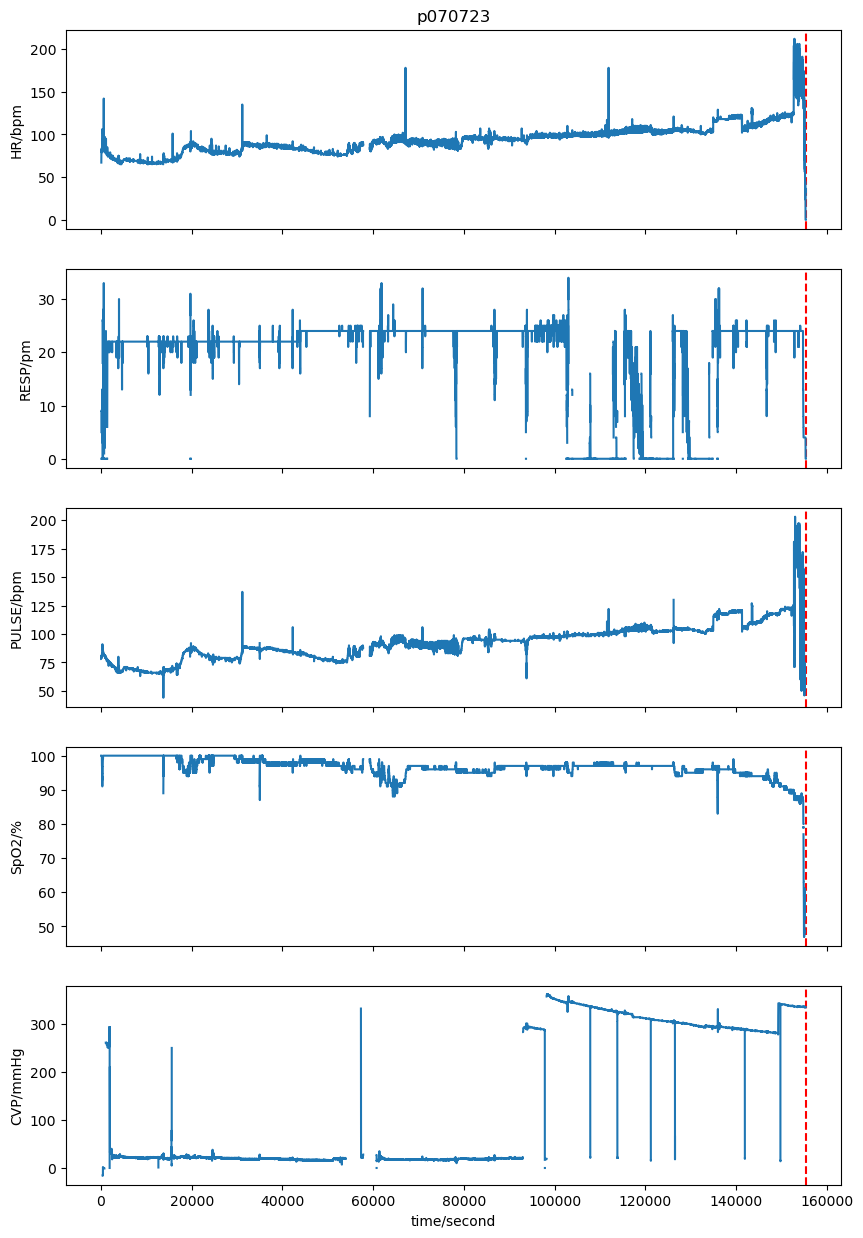

In [6]:
plot_waveform(ca_time_str = CATIME.strftime('%Y-%m-%d %H:%M:%S'), record_name = RECORDNAME)

In [7]:
# # Retrieve record
# record = get_record(RECORDNAME)
# record_df = record.to_dataframe()

# # get the index of the first non-null value in the DataFrame
# actual_BASETIME = record_df.first_valid_index()

# # get actual CA time as the final valid index of the entire dataframe
# # if the patient is dead
# actual_CATIME = record_df.last_valid_index()

# # get actual splittime
# actual_SPLITTIME = actual_CATIME - datetime.timedelta(hours=2)

# actual_FINISHTIME = actual_CATIME - datetime.timedelta(minutes=5)

# # retrieve the first non-null record using the loc method
# record_df = record_df.loc[actual_BASETIME:actual_CATIME]

# for channel in cfg['CHANNEL_NAMES']:
#     if channel not in record_df.columns:
#         record_df[channel.replace(' ','_')] = 0

# # Sample at 5 second interval
# # take instantaneous value
# record_df = record_df.resample('5S').first()

# # perform preprocessing
# record_df = record_df.interpolate(method='linear').fillna(0)

# # can also consider this alternative:
# # record_df = record_df.resample('5S').mean()

# # Split into two parts:
# # 1. Long before cardiac arrest (anytime - 2hours before STARTTIME)
# # 2. Immediately before cardiac arrest (2 hours - 5 minutes before STARTTIME)
# # record_df['y'] = 0 
# # record_df.loc[:actual_SPLITTIME,'y'] = 0
# # record_df.loc[actual_SPLITTIME:actual_FINISHTIME,'y']=1

# # Drop the remaninig records (last 5 minutes before cardiac arrest)
# # Though we can consider it as +ve sample actually if we lack training data
# # record_df = record_df.loc[:actual_FINISHTIME]

# # define positive and negative
# negative_df = record_df.loc[:actual_SPLITTIME]
# positive_df = record_df.loc[actual_SPLITTIME:actual_FINISHTIME,:]

patientid, positive_df, negative_df = get_record_df(record_name='p070723-2163-11-18-16-28n', 
                                         base_time=None, 
                                         ca_time=datetime.datetime.strptime('2163-11-20 11:37:20', '%Y-%m-%d %H:%M:%S'))

In [8]:
display(positive_df)
display(negative_df)

,HR,RESP,PULSE,SpO2,CVP,etco2,AWRR,NBP_Mean,NBP_Dias,NBP_Sys
2163-11-20 09:37:20,119.0,24.0,118.0,92.0,281.0,0,0,0,0,0
2163-11-20 09:37:25,119.0,24.0,118.0,92.0,281.0,0,0,0,0,0
2163-11-20 09:37:30,117.0,24.0,118.0,92.0,281.0,0,0,0,0,0
2163-11-20 09:37:35,119.0,24.0,118.0,92.0,281.0,0,0,0,0,0
2163-11-20 09:37:40,119.0,24.0,118.0,92.0,282.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2163-11-20 11:32:00,139.0,4.0,58.0,48.0,336.0,0,0,0,0,0
2163-11-20 11:32:05,121.0,4.0,57.0,49.0,336.0,0,0,0,0,0
2163-11-20 11:32:10,117.0,4.0,53.0,49.0,336.0,0,0,0,0,0
2163-11-20 11:32:15,121.0,4.0,51.0,53.0,336.0,0,0,0,0,0


,HR,RESP,PULSE,SpO2,CVP,etco2,AWRR,NBP_Mean,NBP_Dias,NBP_Sys
2163-11-18 16:29:00,NaN,NaN,78.0,100.0,NaN,0,0,0,0,0
2163-11-18 16:29:05,NaN,NaN,80.0,100.0,NaN,0,0,0,0,0
2163-11-18 16:29:10,NaN,NaN,80.0,100.0,NaN,0,0,0,0,0
2163-11-18 16:29:15,NaN,NaN,79.0,100.0,NaN,0,0,0,0,0
2163-11-18 16:29:20,NaN,NaN,79.0,100.0,NaN,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2163-11-20 09:37:00,119.0,24.0,118.0,92.0,282.0,0,0,0,0,0
2163-11-20 09:37:05,119.0,24.0,118.0,92.0,282.0,0,0,0,0,0
2163-11-20 09:37:10,119.0,24.0,118.0,92.0,282.0,0,0,0,0,0
2163-11-20 09:37:15,119.0,24.0,118.0,92.0,282.0,0,0,0,0,0


In [9]:
# Create x, y, and a arr for negative
x_negative_arr = create_batch(negative_df)
y_negative_arr = get_arr(x_negative_arr,0)
a_negative_arr = get_arr(x_negative_arr,AGE)

# Create x, y, and a arr for positive
x_positive_arr = create_batch(positive_df)
y_positive_arr = get_arr(x_positive_arr,1)
a_positive_arr = get_arr(x_positive_arr,AGE)

# Concatenating all arrays
x_arr = np.concatenate([x_negative_arr,x_positive_arr])
y_arr = np.concatenate([y_negative_arr,y_positive_arr])
a_arr = np.concatenate([a_negative_arr,a_positive_arr])

# converts from (n, 120, 10) to (n, 10, 120) 
# x_arr = np.swapaxes(x_arr,1,2)

# Split between train + test
from sklearn.model_selection import ShuffleSplit # or StratifiedShuffleSplit
sss = ShuffleSplit(n_splits=1, test_size=0.3, random_state=24)
sss.get_n_splits(x_arr, y_arr)
train_index, valtest_index = next(sss.split(x_arr, y_arr)) 

X_train, X_valtest = x_arr[train_index], x_arr[valtest_index] 
a_train, a_valtest = a_arr[train_index], a_arr[valtest_index] 
y_train, y_valtest = y_arr[train_index], y_arr[valtest_index]

# Split between val and test
sss = ShuffleSplit(n_splits=1, test_size=0.5, random_state=24)
sss.get_n_splits(X_valtest, y_valtest)
val_index, test_index = next(sss.split(X_valtest, y_valtest)) 

X_val, X_test = X_valtest[val_index], X_valtest[test_index] 
a_val, a_test = a_valtest[val_index], a_valtest[test_index] 
y_val, y_test = y_valtest[val_index], y_valtest[test_index]

# Create dataloader
dataset = load_dataset(x_arr, a_arr, y_arr)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0, drop_last=True)

# Print the data out
# for i, (input, age, target) in enumerate(data_loader):
#     print(input,age,target)

In [10]:
print(f"Training shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (299, 10, 120)
Validation shape: (64, 10, 120)
Testing shape: (65, 10, 120)


In [11]:
pd.DataFrame(X_test[0].T)

,0,1,2,3,4,5,6,7,8,9
0,78.0,22.0,79.0,100.0,20.0,0.0,0.0,0.0,0.0,0.0
1,78.0,22.0,78.0,100.0,20.0,0.0,0.0,0.0,0.0,0.0
2,78.0,22.0,78.0,100.0,20.0,0.0,0.0,0.0,0.0,0.0
3,78.0,22.0,78.0,100.0,21.0,0.0,0.0,0.0,0.0,0.0
4,78.0,22.0,78.0,100.0,20.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
115,77.0,22.0,78.0,100.0,20.0,0.0,0.0,0.0,0.0,0.0
116,78.0,22.0,78.0,100.0,20.0,0.0,0.0,0.0,0.0,0.0
117,78.0,22.0,78.0,100.0,20.0,0.0,0.0,0.0,0.0,0.0
118,78.0,22.0,78.0,100.0,20.0,0.0,0.0,0.0,0.0,0.0


In [12]:
data_df = pd.DataFrame(X_test[0].T)

In [13]:
# Creating a mock x test file
data_df.to_csv(cfg['EXPLOREPATH']+'/X.TESTINPUT',index=False)

In [70]:
# from plots import plot_learning_curves, plot_confusion_matrix

#TODO: https://pytorch.org/docs/stable/notes/windows.html#multiprocessing-error-without-if-clause-protection

# # Set a correct path to the seizure data file you downloaded
# PATH_TRAIN_FILE = "../data/seizure/seizure_train.csv"
# PATH_VALID_FILE = "../data/seizure/seizure_validation.csv"
# PATH_TEST_FILE = "../data/seizure/seizure_test.csv"

# # Path for saving model
PATH_OUTPUT = "../model/"
# os.makedirs(PATH_OUTPUT, exist_ok=True)

# # Some parameters
# MODEL_TYPE = 'MLP'  # TODO: Change this to 'MLP', 'CNN', or 'RNN' according to your task
NUM_EPOCHS = 100
BATCH_SIZE = 16
USE_CUDA = False  # Set 'True' if you want to use GPU
NUM_WORKERS = 0  # Number of threads used by DataLoader. You can adjust this according to your machine spec.

model = MyCNN()
save_file = 'MyCNN5.pth'

device = torch.device("cuda" if USE_CUDA and torch.cuda.is_available() else "cpu")
torch.manual_seed(1)
if device.type == "cuda":
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

train_dataset = load_dataset(X_train, a_train, y_train)
valid_dataset = load_dataset(X_val,   a_val,   y_val)
test_dataset  = load_dataset(X_test,  a_test,  y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model Summary: {pytorch_total_params}")

# Delete me
def count_parameters(model):
    # table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        print(f"{name}: {params}")
        total_params+=params
    # print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

best_val_acc = 0.0
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(NUM_EPOCHS):
	train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer, epoch)
	valid_loss, valid_accuracy, valid_results = evaluate(model, device, valid_loader, criterion)

	train_losses.append(train_loss)
	valid_losses.append(valid_loss)

	train_accuracies.append(train_accuracy)
	valid_accuracies.append(valid_accuracy)

	is_best = valid_accuracy > best_val_acc  # let's keep the model that has the best accuracy, but you can also use another metric.
	if is_best:
		best_val_acc = valid_accuracy
		torch.save(model, cfg['MODELPATH'], _use_new_zipfile_serialization=False)

# plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies)

best_model = torch.load(cfg['MODELPATH'])
test_loss, test_accuracy, test_results = evaluate(best_model, device, test_loader, criterion)


Model Summary: 7028
conv1.weight: 200
conv1.bias: 4
conv2.weight: 20
conv2.bias: 1
lstm.weight_ih_l0: 3456
lstm.weight_hh_l0: 1024
lstm.bias_ih_l0: 64
lstm.bias_hh_l0: 64
lstm.weight_ih_l1: 1024
lstm.weight_hh_l1: 1024
lstm.bias_ih_l1: 64
lstm.bias_hh_l1: 64
out.weight: 16
out.bias: 1
age_fn.weight: 1
age_fn.bias: 1
Total Trainable Params: 7028


RuntimeError: The size of tensor a (8) must match the size of tensor b (16) at non-singleton dimension 0

In [15]:
for i in test_loader:
    print(i)
    break

[tensor([[[ 78.,  78.,  78.,  ...,  78.,  78.,  78.],
         [ 22.,  22.,  22.,  ...,  22.,  22.,  22.],
         [ 79.,  78.,  78.,  ...,  78.,  78.,  78.],
         ...,
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.]],

        [[ 99.,  99.,  99.,  ...,  99.,  99.,  99.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [ 99.,  99.,  99.,  ...,  99.,  99.,  99.],
         ...,
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.]],

        [[ 86.,  87.,  86.,  ...,  85.,  85.,  84.],
         [ 24.,  24.,  24.,  ...,  24.,  24.,  24.],
         [ 88.,  86.,  86.,  ...,  92.,  86.,  85.],
         ...,
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.]]

In [16]:
print(test_results)

[(0.0, 0, 3.005064641570243e-09), (0.0, 0, 4.187945101818968e-09), (0.0, 0, 5.624413823568375e-09), (0.0, 0, 7.054474782108855e-09), (0.0, 0, 8.255101491272399e-09), (1.0, 0, 9.133453104936962e-09), (0.0, 0, 9.77875025398589e-09), (0.0, 0, 1.024411400152303e-08), (0.0, 0, 1.0566192365502047e-08), (0.0, 0, 1.0802351013694533e-08), (0.0, 0, 1.0975351294462143e-08), (0.0, 0, 1.1101993990791925e-08), (0.0, 0, 1.1195237625827303e-08), (0.0, 0, 1.1253639797814685e-08), (0.0, 0, 1.130359184031704e-08), (0.0, 0, 1.1344543082714154e-08), (0.0, 0, 3.0010494089793838e-09), (0.0, 0, 4.182485024983862e-09), (0.0, 0, 5.618892018333099e-09), (0.0, 0, 7.0032215582216395e-09), (1.0, 0, 8.15925371711046e-09), (0.0, 0, 9.051095872791848e-09), (0.0, 0, 9.718079674314595e-09), (0.0, 0, 1.0191902433120958e-08), (0.0, 0, 1.0526424176759974e-08), (0.0, 0, 1.0763644198164002e-08), (1.0, 0, 1.0933230321086285e-08), (0.0, 0, 1.1055758974976015e-08), (0.0, 0, 1.1156143564505783e-08), (0.0, 0, 1.123478909903497e-0

That was for training the model. Now, we expect the model to take in some input. How will the input be?

In [9]:

def load_dataset_production(x_arr, age_arr):
	"""
	:param path: a path to the seizure data CSV file
	:return dataset: a TensorDataset consists of a data Tensor and a target Tensor
	"""
	# Casting in pytorch tensor
	data = torch.from_numpy(x_arr).type(torch.FloatTensor)
	age = torch.from_numpy(age_arr).type(torch.FloatTensor)

	# x[torch.isnan(x)] = 0

	# Need to be of size (N, Cn, L)
	# N: batch size
	# Cn: number of channels
	# L: length of the sequence
	# data = data.reshape((data.shape[0], data.shape[1], data.shape[2]))
	dataset = TensorDataset(data, age.float())

	return dataset


Making an inference on one patient's one waveform data

In [18]:
cfg['MODELPATH'] = '../model/MyCNN5.pth'

# Loading the model
model = torch.load(cfg['MODELPATH'])

model.eval()

# Assume that data_df comes in as a pandas dataframe
data_df = pd.read_csv(cfg['EXPLOREPATH']+'/X.TESTINPUT')

# Generate an feature array
x_arr = create_batch(data_df, window_size=cfg['WINDOWSIZE'], overlap_pct = 0)

# converts from (n, 120, 10) to (n, 10, 120) 
print(x_arr.shape)
# x_arr = np.swapaxes(x_arr,1,2)

# generate an age array of the same size as x_arr
a_arr = get_arr(x_arr,AGE)

with torch.no_grad():
	x_arr = torch.from_numpy(x_arr).type(torch.FloatTensor).to(device).float()
	a_arr = torch.from_numpy(a_arr).type(torch.FloatTensor).unsqueeze(0).to(device).float()
	output = model(x_arr, a_arr)
	x_arr=x_arr.to(device)
	a_arr=a_arr.to(device)
	y = torch.sigmoid(output).detach().to('cpu')
	y_pred = y.round().long().numpy().tolist()
	y_prob = y.numpy().tolist()

	print(y_prob)
	print(y_pred)
# Prove that this is the same results as the evaluation set 

(1, 10, 120)
[3.005064641570243e-09]
[0]


Finding a way of uploading the age to "patients" in dataframe


In [19]:
x_train_arr = []
x_val_arr = []
x_test_arr = []
y_train_arr = []
y_val_arr = []
y_test_arr = []
a_train_arr = []
a_val_arr = []
a_test_arr = []

In [399]:
create_batch(positive_df)


array([[[ 90.82502439,  91.53343637,  92.24184836, ..., 116.34437621,
         112.65540243, 108.96642865],
        [ 26.70808548,  28.23310405,  29.75812263, ...,  32.8558315 ,
          33.06105828,  33.26628507],
        [ 98.95466715,  99.84667071, 100.73867427, ..., 125.23087857,
         121.94887967, 118.66688076],
        ...,
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]]])

In [10]:
def get_arrays(positive_df, negative_df, age): # Create x, y, and a arr for negative
    if len(positive_df)<120 and len(negative_df)<120:
        print("None obtained")
        return np.empty((0,10,120)), np.empty(0), np.empty(0)
    
    if len(positive_df)<120:
        print("Only negative")
        x_negative_arr = create_batch(negative_df)
        y_negative_arr = get_arr(x_negative_arr,0)
        a_negative_arr = get_arr(x_negative_arr,age)
        return x_negative_arr,y_negative_arr,a_negative_arr

    # Create x, y, and a arr for positive
    if len(negative_df)<120:
        print("Only positive")
        x_positive_arr = create_batch(positive_df)
        y_positive_arr = get_arr(x_positive_arr,1)
        a_positive_arr = get_arr(x_positive_arr,age)
        return x_positive_arr,y_positive_arr,a_positive_arr

    # Concatenating all arrays
    else:
        print("Both")
        x_negative_arr = create_batch(negative_df)
        y_negative_arr = get_arr(x_negative_arr,0)
        a_negative_arr = get_arr(x_negative_arr,age)

        x_positive_arr = create_batch(positive_df)
        y_positive_arr = get_arr(x_positive_arr,1)
        a_positive_arr = get_arr(x_positive_arr,age)

        x_arr = np.concatenate([x_negative_arr,x_positive_arr])
        y_arr = np.concatenate([y_negative_arr,y_positive_arr])
        a_arr = np.concatenate([a_negative_arr,a_positive_arr])
    
    return x_arr, y_arr, a_arr


In [14]:
# Using the data from patients_waveform.csv
waveform_df=pd.read_csv(F'{cfg["DATAPATH"]}/patients_waveform.csv', parse_dates=['STARTTIME','BASETIME','FINISHTIME'])
# valid_records_df = waveform_df.query("BASETIME<=STARTTIME & STARTTIME<=FINISHTIME")[['RECORDNAME','BASETIME','STARTTIME','FINISHTIME','SPLIT']]
valid_records_df = waveform_df[['RECORDNAME','BASETIME','STARTTIME','FINISHTIME','SPLIT']]

# remove timestamp awareness from BASETIME and STARTTIME
valid_records_df['BASETIME'] = valid_records_df['BASETIME'].dt.tz_localize(None)
valid_records_df['STARTTIME'] = valid_records_df['STARTTIME'].dt.tz_localize(None)
valid_records_df['FINISHTIME'] = valid_records_df['FINISHTIME'].dt.tz_localize(None)
valid_records_df

/var/folders/lc/wjv2l4cd19s4276v_sgzt_q40000gn/T/ipykernel_2048/4224680163.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_records_df['BASETIME'] = valid_records_df['BASETIME'].dt.tz_localize(None)
/var/folders/lc/wjv2l4cd19s4276v_sgzt_q40000gn/T/ipykernel_2048/4224680163.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_records_df['STARTTIME'] = valid_records_df['STARTTIME'].dt.tz_localize(None)
/var/folders/lc/wjv2l4cd19s4276v_sgzt_q40000gn/T/ipykernel_2048/4224680163.py:9: SettingWithCo

,RECORDNAME,BASETIME,STARTTIME,FINISHTIME,SPLIT
0,p041035-2135-02-06-08-02n,2135-02-06 08:02:00,2135-02-06 16:27:00,2135-02-06 11:14:00,test
1,p043926-2197-05-14-15-06n,2197-05-14 15:06:00,2197-05-14 17:28:00,2197-05-17 17:16:00,val
2,p044298-2187-06-28-23-57n,2187-06-28 23:57:00,2187-06-28 19:00:00,2187-07-03 14:21:00,val
3,p044298-2187-06-28-23-57n,2187-06-28 23:57:00,2187-06-28 19:10:00,2187-07-03 14:21:00,train
4,p046154-2196-07-29-02-30n,2196-07-29 02:30:00,2196-07-29 06:00:00,2196-07-29 06:47:00,train
5,p046927-2130-03-10-11-48n,2130-03-10 11:48:00,2130-03-10 16:28:00,2130-03-11 13:29:00,train
6,p050015-2138-12-20-19-42n,2138-12-20 19:42:00,2138-12-20 23:53:00,2138-12-20 22:06:00,val
7,p052529-2184-03-10-11-01n,2184-03-10 11:01:00,2184-03-10 05:10:00,2184-03-10 12:50:00,test
8,p052529-2184-03-10-13-16n,2184-03-10 13:16:00,2184-03-10 05:10:00,2184-03-11 12:25:00,train
9,p054183-2165-09-27-20-05n,2165-09-27 20:05:00,2165-09-27 21:01:00,2165-09-27 21:13:00,train


In [16]:
x_train_arr, x_val_arr, x_test_arr  = np.empty((0,10,120)),np.empty((0,10,120)),np.empty((0,10,120))
y_train_arr, y_val_arr, y_test_arr = np.empty((0)),np.empty((0)),np.empty((0))
a_train_arr, a_val_arr, a_test_arr = np.empty((0)),np.empty((0)),np.empty((0))

for idx, row in valid_records_df.iterrows():
    print(row['RECORDNAME'])
    patient_id, positive_df, negative_df = get_record_df(row['RECORDNAME'], row['BASETIME'], row['STARTTIME'])
    age = get_patient_age(int(patient_id[1:]), row['BASETIME'])
    # age = 65.0
    x_arr, y_arr, a_arr = get_arrays(positive_df, negative_df, age)
    split = row['SPLIT']
    if split == 'train':
        x_train_arr=np.concatenate([x_train_arr,x_arr])
        y_train_arr=np.concatenate([y_train_arr,y_arr])
        a_train_arr=np.concatenate([a_train_arr,a_arr])

    elif split == 'val':
        x_val_arr=np.concatenate([x_val_arr,x_arr])
        y_val_arr=np.concatenate([y_val_arr,y_arr])
        a_val_arr=np.concatenate([a_val_arr,a_arr])
    elif split == 'test':
        x_test_arr=np.concatenate([x_test_arr,x_arr])
        y_test_arr=np.concatenate([y_test_arr,y_arr])
        a_test_arr=np.concatenate([a_test_arr,a_arr])
    else:
        print("error")

p041035-2135-02-06-08-02n
Only negative
p043926-2197-05-14-15-06n
Both
p044298-2187-06-28-23-57n
None obtained
p044298-2187-06-28-23-57n
None obtained
p046154-2196-07-29-02-30n
Both
p046927-2130-03-10-11-48n
Both
p050015-2138-12-20-19-42n
Both
p052529-2184-03-10-11-01n
None obtained
p052529-2184-03-10-13-16n
None obtained
p054183-2165-09-27-20-05n
Only positive
p056697-2164-08-21-06-43n
None obtained
p060659-2128-05-24-01-01n
None obtained
p062323-2189-10-01-00-11n
Both
p063762-2181-12-04-03-58n
Only positive
p063762-2181-12-04-03-58n
Only positive
p063762-2181-12-04-03-58n
Both
p070723-2163-11-18-16-28n
None obtained
p082104-2177-04-29-16-16n
Both
p082512-2114-12-22-08-46n
None obtained
p082512-2114-12-22-09-16n
Both
p083873-2143-04-16-06-49n
Both
p086678-2196-06-07-00-34n
Only positive
p087675-2104-12-05-03-53n
Both
p096060-2112-12-16-14-20n
Both
p096305-2158-11-01-12-24n
None obtained
p099756-2191-12-23-02-00n
Both
p099756-2191-12-23-02-00n
Both
p094255-2139-07-30-15-58n
Both


In [17]:
# Create dataloader
dataset = load_dataset(x_arr, a_arr, y_arr)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0, drop_last=True)

In [18]:
print(x_train_arr.shape)
print(x_val_arr.shape)
print(x_test_arr.shape)

print(y_train_arr.shape)
print(y_val_arr.shape)
print(y_test_arr.shape)

print(a_train_arr.shape)
print(a_val_arr.shape)
print(a_test_arr.shape)

(399, 10, 120)
(310, 10, 120)
(164, 10, 120)
(399,)
(310,)
(164,)
(399,)
(310,)
(164,)


In [19]:
print(x_train_arr)

[[[ 50.  50.  60. ...  50.  50.  50.]
  [  0.   0.   8. ...  24.  24.  27.]
  [  0.   0.   0. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]]

 [[ 50.  52.  55. ...  50.  50.  50.]
  [ 32.  31.  29. ...  25.  23.  21.]
  [  0.   0.   0. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]]

 [[ 60.  63.  50. ...  56.  50.  50.]
  [ 39.  34.  30. ...  36.  41.  41.]
  [  0.   0.   0. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]]

 ...

 [[ 51.  60.  65. ...  33.  33.  33.]
  [ 25.  25.  26. ...   0.   0.   0.]
  [122. 122. 122. ... 122. 122. 122.]
  ...
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]]

 [[ 38.  39.  38. ...  33.  33.  33.]
  [  0.   0.

In [20]:
print(y_train_arr)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [416]:
!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 3.4 MB/s eta 0:00:00a 0:00:01


In [82]:
# bookmark
# from plots import plot_learning_curves, plot_confusion_matrix
#TODO: https://pytorch.org/docs/stable/notes/windows.html#multiprocessing-error-without-if-clause-protection

import torch
torch.manual_seed(0)
# Path for saving model
PATH_OUTPUT = "../model/"

# Some parameters
NUM_EPOCHS = 300
BATCH_SIZE = 16 
USE_CUDA = False  # Set 'True' if you want to use GPU
NUM_WORKERS = 0  # Number of threads used by DataLoader. You can adjust this according to your machine spec.

model = MyCNN()
save_file = 'MyCNN7.pth'

device = torch.device("cuda" if USE_CUDA and torch.cuda.is_available() else "cpu")
torch.manual_seed(1)
if device.type == "cuda":
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

train_dataset = load_dataset(x_train_arr, a_train_arr, y_train_arr)
valid_dataset = load_dataset(x_val_arr,   a_val_arr,   y_val_arr)
test_dataset  = load_dataset(x_test_arr,  a_test_arr,  y_test_arr)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model Summary: {pytorch_total_params}")

# Delete me
def count_parameters(model):
    # table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        print(f"{name}: {params}")
        total_params+=params
    # print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.000005)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

best_val_acc = 0.0
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(NUM_EPOCHS):
	train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer, epoch)
	valid_loss, valid_accuracy, valid_results = evaluate(model, device, valid_loader, criterion)

	train_losses.append(train_loss)
	valid_losses.append(valid_loss)

	train_accuracies.append(train_accuracy)
	valid_accuracies.append(valid_accuracy)

	is_best = valid_accuracy > best_val_acc  # let's keep the model that has the best accuracy, but you can also use another metric.
	if is_best:
		best_val_acc = valid_accuracy
		torch.save(model, cfg['MODELPATH'], _use_new_zipfile_serialization=False)

# plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies)

best_model = torch.load(cfg['MODELPATH'])
train_loss, train_accuracy, train_results = evaluate(best_model, device, train_loader, criterion)
val_loss, val_accuracy, val_results = evaluate(best_model, device, valid_loader, criterion)
test_loss, test_accuracy, test_results = evaluate(best_model, device, test_loader, criterion)


Model Summary: 5821
conv1.weight: 200
conv1.bias: 4
conv2.weight: 20
conv2.bias: 1
out1.weight: 567
out1.bias: 1
lstm.weight_ih_l0: 1664
lstm.weight_hh_l0: 1024
lstm.bias_ih_l0: 64
lstm.bias_hh_l0: 64
lstm.weight_ih_l1: 1024
lstm.weight_hh_l1: 1024
lstm.bias_ih_l1: 64
lstm.bias_hh_l1: 64
out.weight: 16
out.bias: 1
out2.weight: 16
out2.bias: 1
age_fn.weight: 1
age_fn.bias: 1
Total Trainable Params: 5821
Epoch: [0][0/25]	Time 0.006 (0.006)	Data 0.001 (0.001)	Loss 0.6895 (0.6895)	Accuracy 62.500 (62.500)
Epoch: [0][10/25]	Time 0.004 (0.005)	Data 0.000 (0.000)	Loss 0.6939 (0.6924)	Accuracy 50.000 (46.591)
Epoch: [0][20/25]	Time 0.003 (0.004)	Data 0.000 (0.000)	Loss 0.6934 (0.6921)	Accuracy 37.500 (50.595)
Test: [0/20]	Time 0.001 (0.001)	Loss 0.6970 (0.6970)	Accuracy 12.500 (12.500)
Test: [10/20]	Time 0.001 (0.001)	Loss 0.6843 (0.6925)	Accuracy 100.000 (53.409)
Epoch: [1][0/25]	Time 0.003 (0.003)	Data 0.000 (0.000)	Loss 0.6909 (0.6909)	Accuracy 75.000 (75.000)
Epoch: [1][10/25]	Time 0.003 (

/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/torch/serialization.py:474: UserWarning: Couldn't retrieve source code for container of type MyCNN. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


Epoch: [1][20/25]	Time 0.003 (0.004)	Data 0.000 (0.000)	Loss 0.6921 (0.6923)	Accuracy 43.750 (51.488)
Test: [0/20]	Time 0.001 (0.001)	Loss 0.6973 (0.6973)	Accuracy 12.500 (12.500)
Test: [10/20]	Time 0.001 (0.001)	Loss 0.6839 (0.6925)	Accuracy 100.000 (53.409)
Epoch: [2][0/25]	Time 0.003 (0.003)	Data 0.000 (0.000)	Loss 0.6900 (0.6900)	Accuracy 62.500 (62.500)
Epoch: [2][10/25]	Time 0.003 (0.003)	Data 0.000 (0.000)	Loss 0.6918 (0.6913)	Accuracy 50.000 (56.250)
Epoch: [2][20/25]	Time 0.003 (0.003)	Data 0.000 (0.000)	Loss 0.6928 (0.6921)	Accuracy 43.750 (54.167)
Test: [0/20]	Time 0.001 (0.001)	Loss 0.6976 (0.6976)	Accuracy 12.500 (12.500)
Test: [10/20]	Time 0.001 (0.001)	Loss 0.6836 (0.6925)	Accuracy 100.000 (53.409)
Epoch: [3][0/25]	Time 0.004 (0.004)	Data 0.000 (0.000)	Loss 0.6914 (0.6914)	Accuracy 56.250 (56.250)
Epoch: [3][10/25]	Time 0.004 (0.003)	Data 0.000 (0.000)	Loss 0.6897 (0.6923)	Accuracy 62.500 (50.568)
Epoch: [3][20/25]	Time 0.004 (0.004)	Data 0.000 (0.000)	Loss 0.6926 (0.692

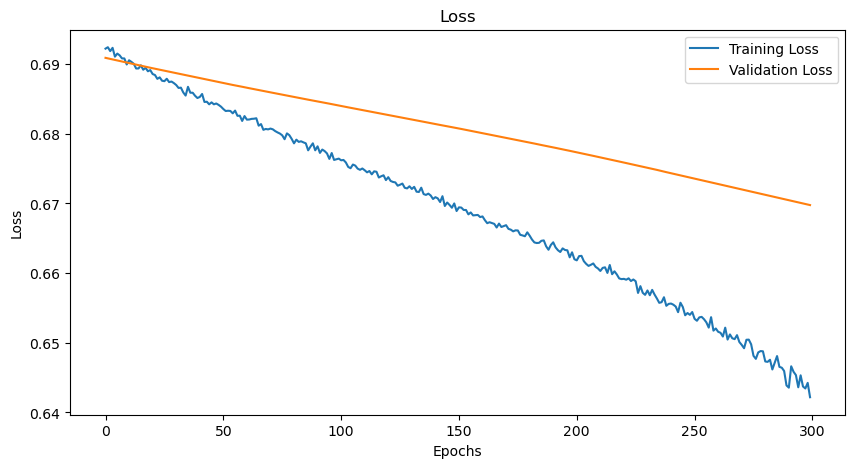

In [83]:
# Plot training training, validation and test loss
plt.figure(figsize=(10, 5))
plt.title("Loss")
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# This might point to the fact that the validation set is easier than training

In [86]:
# Find the classification metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
print(classification_report(y_test_arr, [i[2] > 0.45 for i in test_results]))
print(classification_report(y_val_arr, [i[2] > 0.45 for i in val_results]))
print(classification_report(y_train_arr, [i[2] > 0.45 for i in train_results]))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       123
         1.0       0.25      1.00      0.40        41

    accuracy                           0.25       164
   macro avg       0.12      0.50      0.20       164
weighted avg       0.06      0.25      0.10       164

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       192
         1.0       0.38      1.00      0.55       118

    accuracy                           0.38       310
   macro avg       0.19      0.50      0.28       310
weighted avg       0.14      0.38      0.21       310

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       298
         1.0       0.25      1.00      0.40       101

    accuracy                           0.25       399
   macro avg       0.13      0.50      0.20       399
weighted avg       0.06      0.25      0.10       399



/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

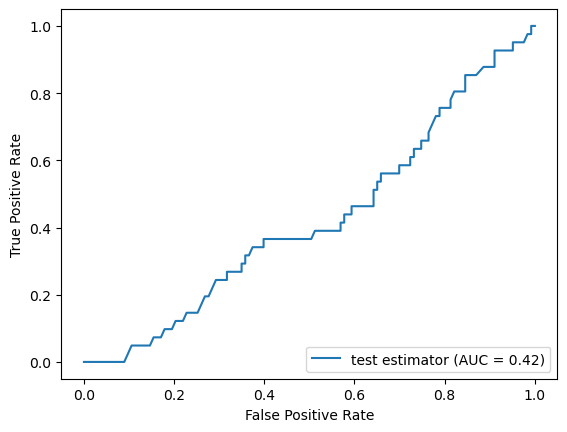

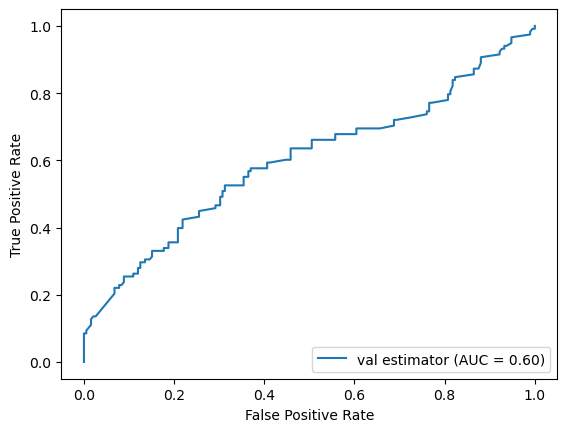

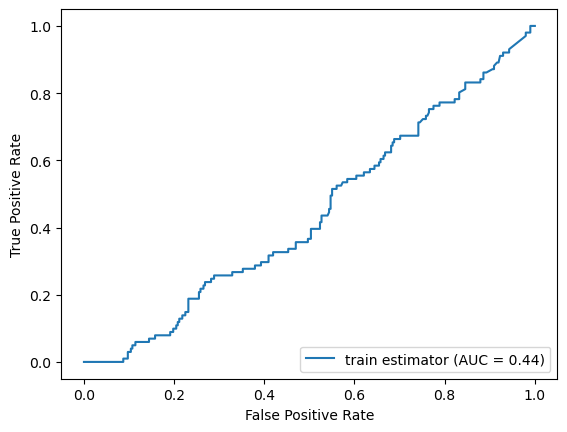

In [87]:
# Nice, we manage to get this! 

fpr, tpr, thresholds = roc_curve(y_test_arr, [i[2] for i in test_results])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='test estimator')
display.plot()
plt.show()

fpr, tpr, thresholds = roc_curve(y_val_arr, [i[2] for i in val_results])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='val estimator')
display.plot()
plt.show()

fpr, tpr, thresholds = roc_curve(y_train_arr, [i[2] for i in train_results])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='train estimator')
display.plot()
plt.show()

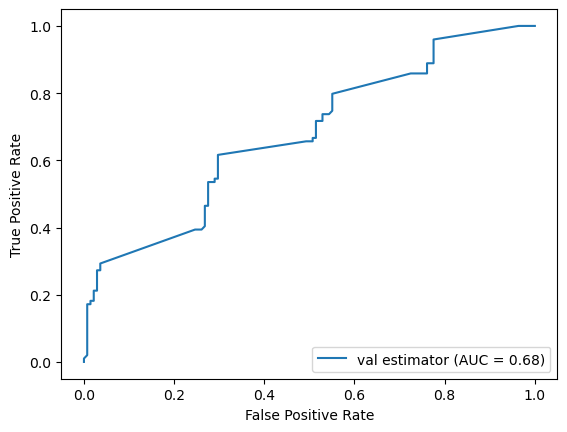

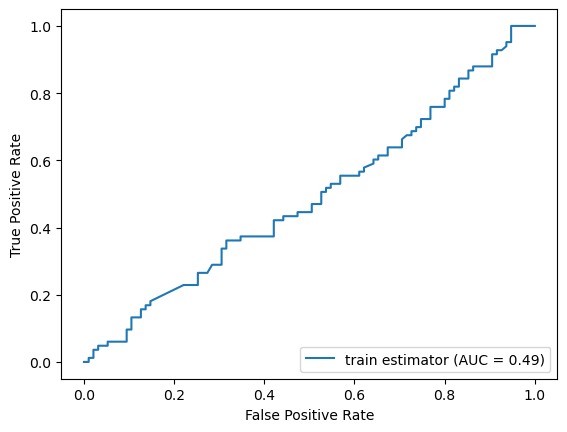

In [181]:
# Nice, we manage to get this! 
fpr, tpr, thresholds = roc_curve(y_val_arr, [i[2] for i in val_results])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='val estimator')
display.plot()
plt.show()

fpr, tpr, thresholds = roc_curve(y_train_arr, [i[2] for i in train_results])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='train estimator')
display.plot()
plt.show()

In [377]:
x_test_arr.shape

(51, 10, 120)

In [78]:
# learning an sklearn model and see how the result is like.
# This is an attempt to see if there is a bug with the data, or a bug with the model


logreg = LogisticRegression(max_iter=5000)
logreg.fit(x_train_arr.reshape(178,1200), y_train_arr)

# Make prediction on validation set
y_pred = logreg.predict_proba(x_val_arr.reshape(237,1200))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_val_arr, y_pred[:,1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='val estimator')
display.plot()
plt.show()

# Make prediction on validation set
y_pred = logreg.predict_proba(x_test_arr.reshape(51,1200))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_arr, y_pred[:,1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()


# Result shows that there are indeed signals to be learned from the data.
# This indicates that there is potentially a bug with the model

ValueError: cannot reshape array of size 478800 into shape (178,1200)

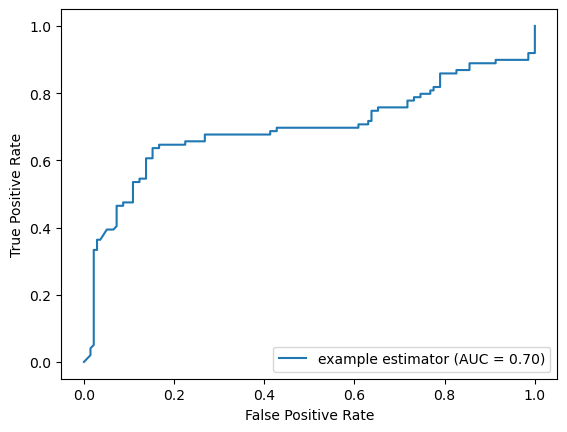

In [58]:
# learning an sklearn model and see how the result is like.
# This is an attempt to see if there is a bug with the data, or a bug with the model
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay,roc_curve,auc

logreg = SVC(probability=True, C = 0.01, kernel = 'sigmoid')
logreg.fit(x_train_arr.reshape(178,1200), y_train_arr)

# Make prediction on validation set
y_pred = logreg.predict_proba(x_val_arr.reshape(237,1200))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_val_arr, y_pred[:,1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

# Result shows that there are indeed signals to be learned from the data.
# This indicates that there is potentially a bug with the model

In [ ]:
# Ther is clearly a bug in here somewhere.
# We will try to figure it out

In [414]:
positive_df

,HR,RESP,PULSE,CVP,etco2,SpO2,AWRR,NBP_Mean,NBP_Dias,NBP_Sys
2191-12-23 09:00:00,136.528086,14.483004,135.112286,12.022364,0.0,0.0,0.0,0.0,0.0,0.0
2191-12-23 09:00:05,136.546091,14.341348,135.124476,12.025002,0.0,0.0,0.0,0.0,0.0,0.0
2191-12-23 09:00:10,136.564095,14.199692,135.136666,12.027641,0.0,0.0,0.0,0.0,0.0,0.0
2191-12-23 09:00:15,136.582099,14.058036,135.148856,12.030280,0.0,0.0,0.0,0.0,0.0,0.0
2191-12-23 09:00:20,136.600103,13.916381,135.161046,12.032919,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2191-12-23 10:54:40,76.705133,12.373183,31.499974,290.224047,0.0,0.0,0.0,0.0,0.0,0.0
2191-12-23 10:54:45,75.506674,11.845728,31.499974,290.279462,0.0,0.0,0.0,0.0,0.0,0.0
2191-12-23 10:54:50,74.308216,11.318273,31.499974,290.334876,0.0,0.0,0.0,0.0,0.0,0.0
2191-12-23 10:54:55,73.109757,10.790818,31.499974,290.390291,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
get_record('p099756-2191-12-23-02-00n').to_dataframe()

,HR,RESP,PULSE,CVP
2191-12-23 02:00:23.000000000,106.367395,12.957952,NaN,NaN
2191-12-23 02:01:22.999999999,102.833849,12.132937,69.332174,NaN
2191-12-23 02:02:22.999999998,106.881934,23.366485,102.882560,NaN
2191-12-23 02:03:22.999999997,102.017978,20.616179,107.375118,NaN
2191-12-23 02:04:22.999999996,107.095140,15.366291,124.571798,NaN
...,...,...,...,...
2191-12-23 10:56:22.999999464,42.035830,2.067905,NaN,290.468324
2191-12-23 10:57:22.999999463,72.001320,10.282787,NaN,290.002388
2191-12-23 10:58:22.999999462,78.249697,13.782968,NaN,248.149544
2191-12-23 10:59:22.999999461,64.149628,14.200076,NaN,42.336874


In [104]:
patient_id

'p099756'

In [415]:
a,b,c=get_record_df('p041035-2135-02-06-08-02n')
b

,HR,RESP,PULSE,SpO2,NBP Mean,NBP Dias,NBP Sys,etco2,CVP,AWRR
2135-02-06 09:14:10,69.0,21.0,68.0,98.0,77.0,63.0,121.0,0,0,0
2135-02-06 09:14:15,69.0,21.0,69.0,99.0,77.0,63.0,121.0,0,0,0
2135-02-06 09:14:20,69.0,21.0,69.0,99.0,77.0,63.0,121.0,0,0,0
2135-02-06 09:14:25,69.0,21.0,69.0,99.0,77.0,63.0,121.0,0,0,0
2135-02-06 09:14:30,70.0,21.0,69.0,99.0,77.0,63.0,121.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2135-02-06 11:08:45,69.0,14.0,69.0,96.0,76.0,61.0,120.0,0,0,0
2135-02-06 11:08:50,69.0,14.0,68.0,96.0,76.0,61.0,120.0,0,0,0
2135-02-06 11:08:55,70.0,14.0,69.0,96.0,76.0,61.0,120.0,0,0,0
2135-02-06 11:09:00,70.0,14.0,71.0,96.0,76.0,61.0,120.0,0,0,0


In [32]:
# We find the lowest hangest fruit. 
valid_records_list

['p041035-2135-02-06-08-02n',
 'p050015-2138-12-20-19-42n',
 'p082104-2177-04-29-16-16n',
 'p082512-2114-12-22-08-46n',
 'p096060-2112-12-16-14-20n',
 'p099756-2191-12-23-02-00n']

In [78]:
get_record_df(record_name, base_time=None, ca_time=None)

NameError: name 'record_name' is not defined